# Lecture 6 - models for sequences
In what has happened so far, we have focused on data that is sampled independently. That is, we have a data-point $x$, a label $y$ and we'd like to learn a function $f$ that maps $x$ to a prediction $\hat{y}$ or to a distribution over possible $y$ values.

However, so much data is a function of sequences. For example, 
- predicting the next frame of a video. Having the entire history of frames up until that point is pretty helpful.
- predicting the next word in some text. Having the entire history of words up until that point is pretty helpful.
- predicting the time evolution of a dynamical system. This one's a little less obvious but we'll go into it in  a bit. 

As a few examples, consider predicting the future time-evolution of a stock or
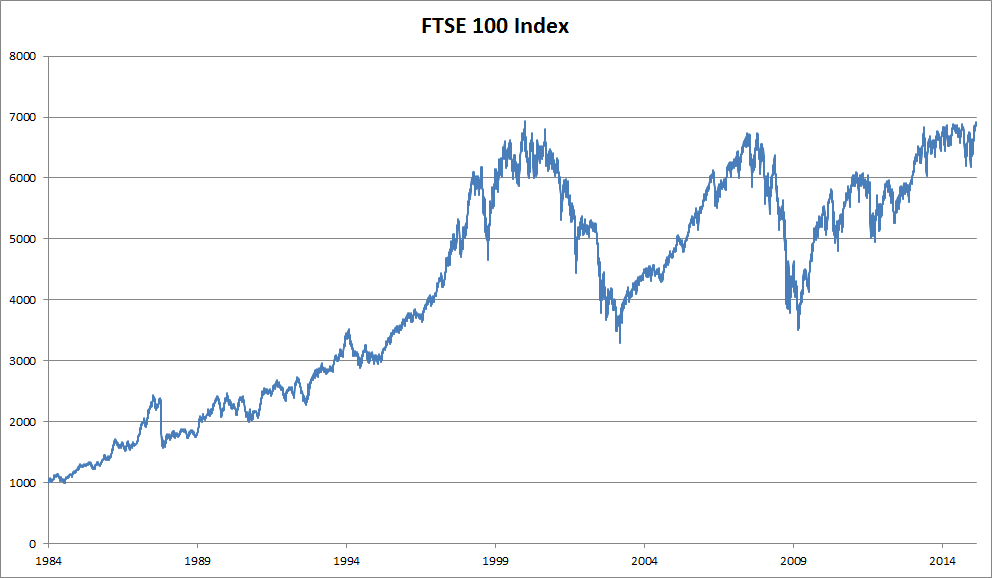

Rather than just a point prediction, we might like to predict the entire sequence and keep predicting. That is, we want to predict $P(x_{t+1}|x_1, x_2, ..., x_t)$ and then use that prediction to predict $P(x_{t+2}|x_1, x_2, ..., x_{t+1})$ and so on.

## Lets talk autoregression 
An *autoregressive model* is a model that depends on its own previous outputs. That is, the prediction at time $t$ depends on the prediction at time $t-1$ and may even depend on the predictions at $t-2$, $t-3$, etc. There are some obvious challenges here:
1. The number of potential inputs are going to grow with each step. 
2. The model is going to have to learn to remember things for a long time.
3. If we do a bad job at a prediction, that bad prediction is going to remain as a potential input to the model and make it worse. 

## Can't we do this with the architectures we've seen before?
In some sense, yes. For example, we could decide "well, we always have a fixed length sequence. Let's just make a really long vector that concatenates all the elements of the sequence and then use a feedforward neural network". This creates a feature vector that has a history and can use the information in that history for better prediction. It's a pretty good idea, it works fairly often, but it has downsides! Can you think of some?

### Some downsides
- The length of the input sequence is fixed. This means that if we train a model on sequences of 5 stacked inputs, we can't now suddenly use 6 stacked inputs.
- It's not set up for *autoregression*. That is, the model can predict the next element, but if you feed that prediction back into the model, it doesn't do a good job predicting the element after that. We'll see an instance of this in a second.

## Some of the challenges of using our existing models for sequnces

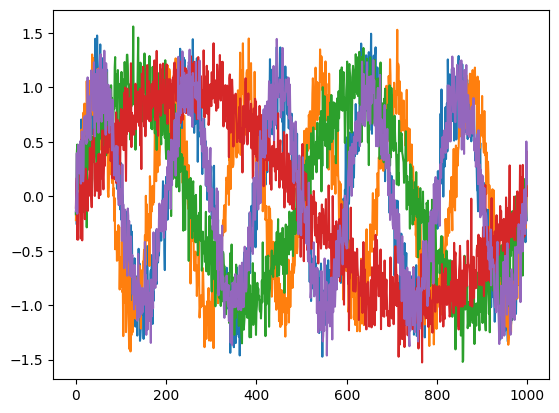

In [39]:
# Generate some time-series data that we will use for training RNNs
import torch
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
torch.manual_seed(1)

# Generate the time-series data
# We make a bunch of different time-series consisting
# of different frequencies of sine waves plus additive noise
num_series = 100
num_timepoints = 1000
time = torch.arange(0, num_timepoints).float()
data = torch.zeros(num_series, num_timepoints)
# (Note, you could and totally should vectorize this)
for i in range(num_series):
    freq = torch.randint(1, 10, (1,))
    data[i] = torch.sin(2 * torch.pi * freq * time / num_timepoints) + torch.randn(num_timepoints) * 0.2
    
# Plot the first 5 time-series
plt.figure()
for i in range(5):
    plt.plot(time, data[i])


In [40]:
# Okay, now lets see if we can successfully predict the next timepoint in the time-series for the first sine wave
# We look at doing a linear regression here for different time lags
class LinearRegressor(torch.nn.Module):
    def __init__(self, total_history=5):
        super(LinearRegressor, self).__init__()
        self.linear = torch.nn.Linear(total_history, 1)
        
    def forward(self, x):
        return self.linear(x)
    
# Okay, now lets turn this into data that's easy to iterate over
# using torch datasets and torch dataloaders
# This is a useful utility class that we will reuse
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, total_history, prediction_offset=0):
        self.data = data
        self.total_history = total_history
        self.prediction_offset = prediction_offset
        
    def __len__(self):
        # This tells pytorch how much data we have
        return len(self.data) - self.total_history - self.prediction_offset
    
    def __getitem__(self, idx):
        # This actually returns the data
        # Note that here we are constructing the features by stacking
        # a bunch of states together
        return self.data[idx:idx+self.total_history], self.data[idx+self.total_history + self.prediction_offset]

# Lets construct a train and a validation set for the first time-series
# what are the features? Well, they're some number of datapoints observed so far
# and the label is the next datapoint
# We're going to be lazy and just make the validation set the latter half of the data

def train_for_history(total_history=5, prediction_offset=1):
    train_split = 0.8
    num_train = int(num_timepoints * train_split)
    train_data = data[0, :num_train]
    val_data = data[0, num_train:]

    train_dataset = TimeSeriesDataset(train_data, total_history, prediction_offset)
    # val_dataset = TimeSeriesDataset(val_data, total_history, prediction_horizon)

    # Okay, now we can use an object called a torch dataloader to iterate over the data
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Okay, now lets train our model
    model = LinearRegressor(total_history)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    num_epochs = 30
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        avg_train_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(x)
            l = loss(y_pred.squeeze(), y)
            l.backward()
            optimizer.step()
            avg_train_loss += l.item()
        train_losses.append(avg_train_loss)
        
        avg_val_loss = 0
        # for i, (x, y) in enumerate(val_dataloader):
        #     y_pred = model(x)
        #     l = loss(y_pred.squeeze(), y)
        #     avg_val_loss += l.item()
        # val_losses.append(avg_val_loss)
        # print(f"Epoch {epoch} Train loss: {train_losses[-1]} Val loss: {val_losses[-1]}")

    # Now lets plot the training and validation losses
    plt.figure()
    plt.plot(train_losses, label='Train loss')
    # plt.plot(val_losses, label='Val loss')
    plt.legend()

    # Now lets plot our predictions
    model.eval()
    with torch.no_grad():
        predictions = []
        for i in range(train_data.shape[0] - total_history - prediction_offset):
            x = train_data[i:i+total_history]
            y = train_data[i+total_history + prediction_offset]
            y_pred = model(x)
            predictions.append(y_pred.item())
    
    plt.figure()
    plt.plot(train_data[total_history+prediction_offset:].numpy(), label='True')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    return model 


LinearRegressor(
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

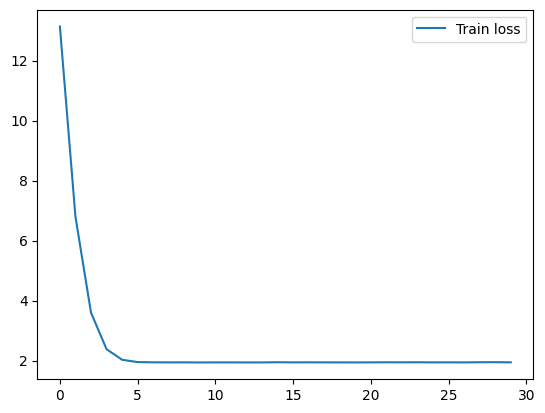

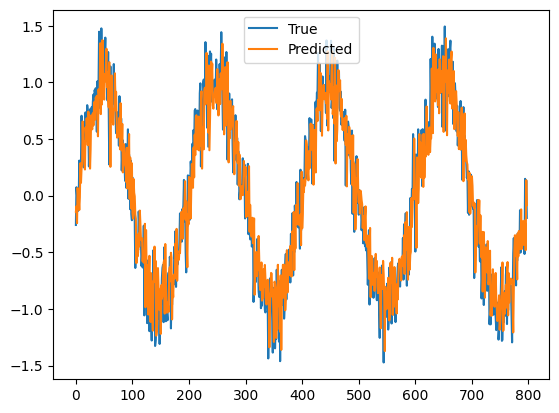

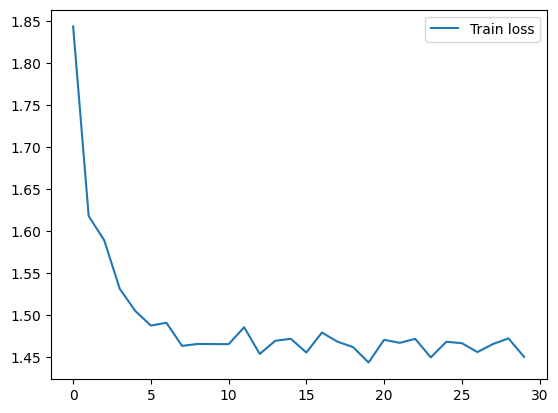

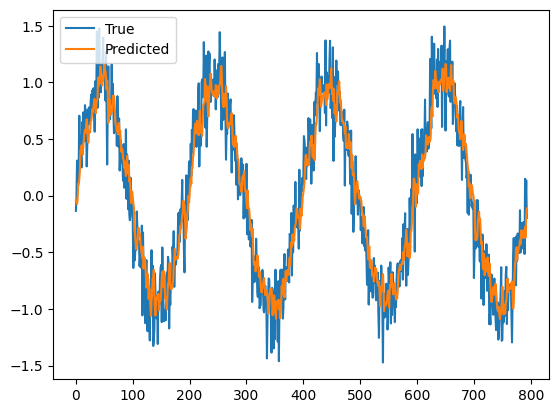

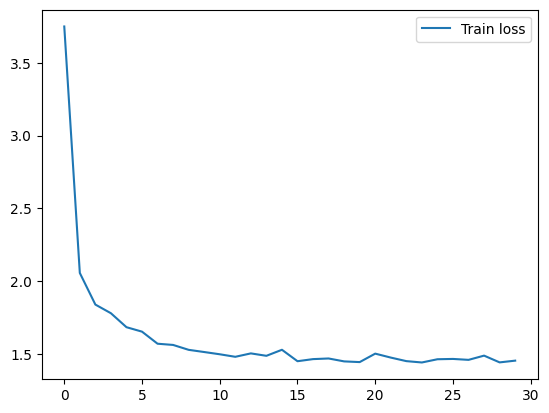

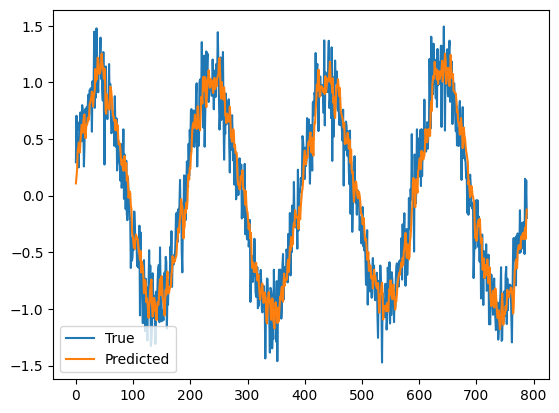

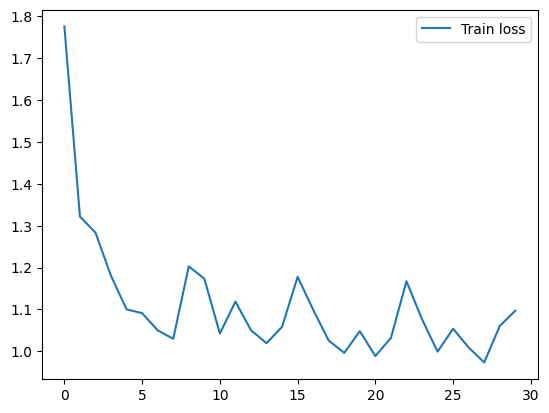

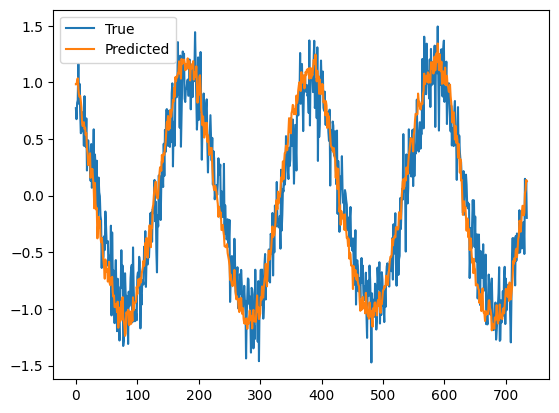

In [41]:
train_for_history(1)
train_for_history(5)
model = train_for_history(10)
train_for_history(64)

LinearRegressor(
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

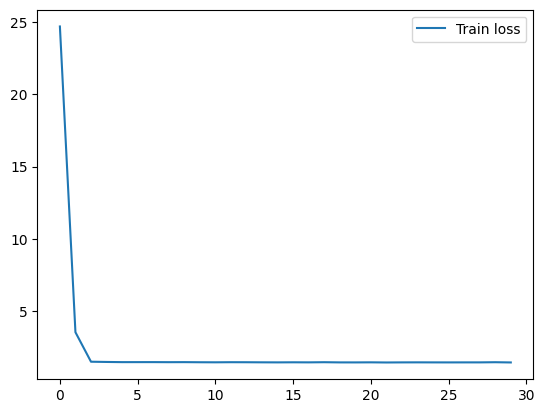

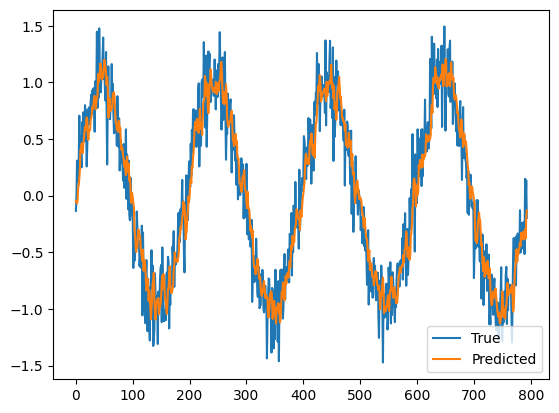

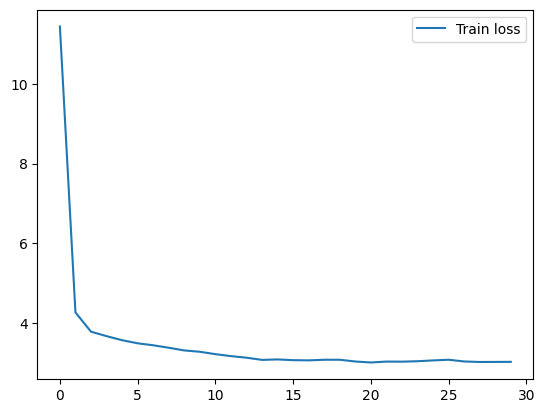

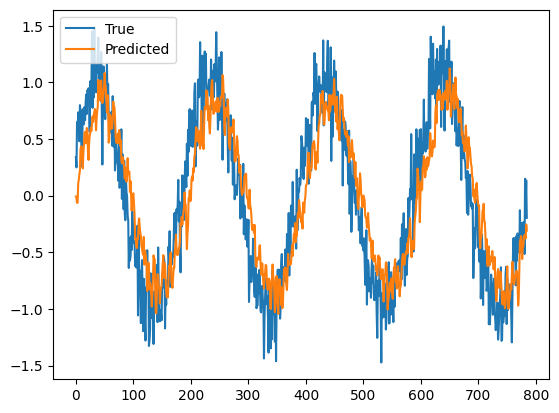

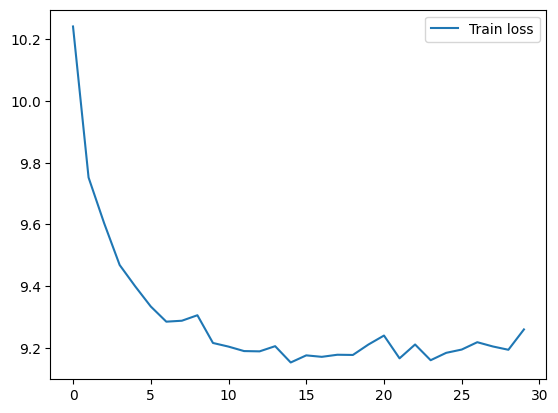

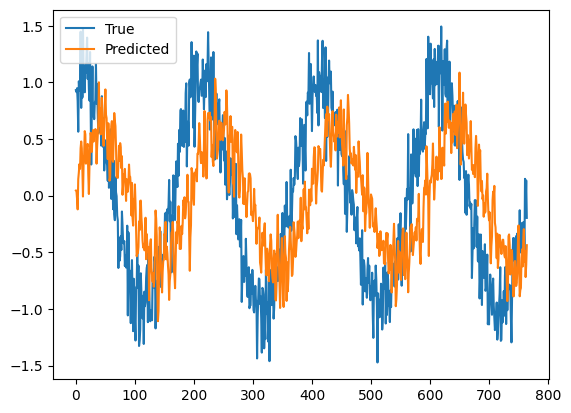

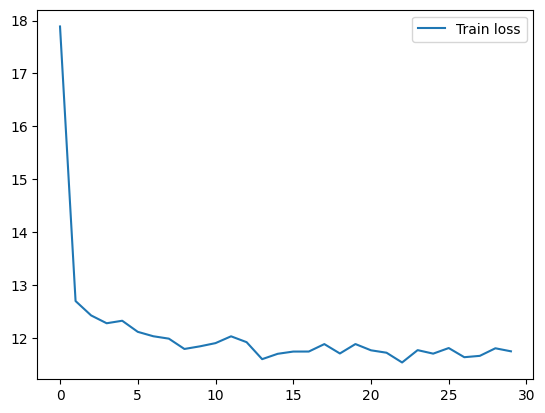

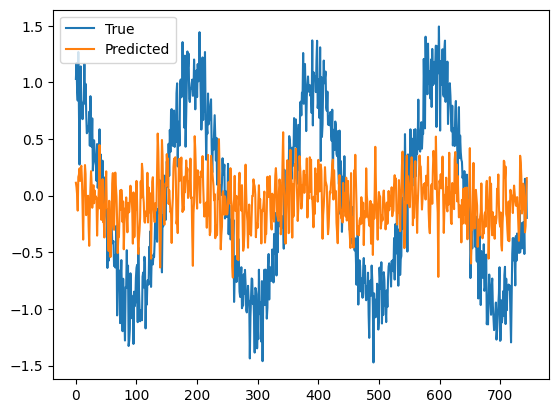

In [42]:
# now lets do the same thing for longer horizon predictions
train_for_history(5, 1)
train_for_history(5, 10)
train_for_history(5, 30)
train_for_history(5, 50)

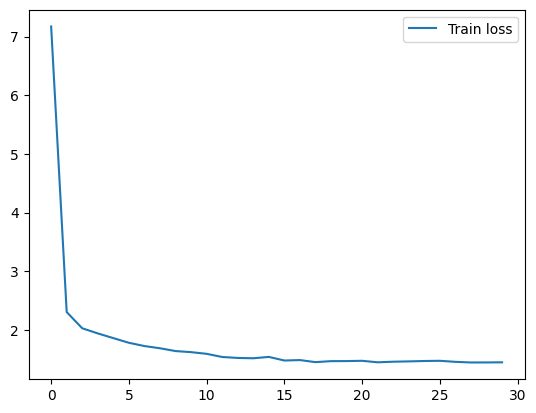

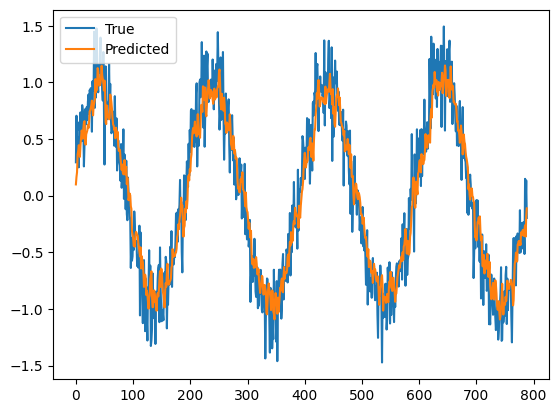

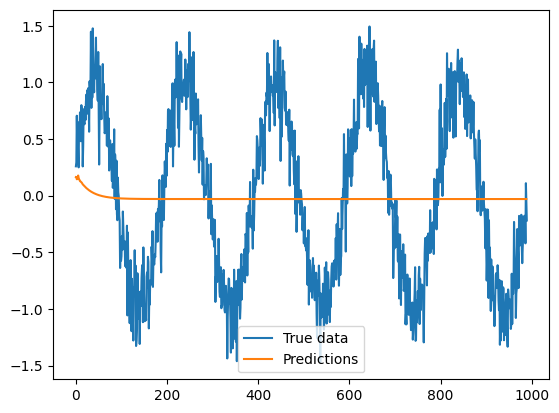

In [43]:
# At this point you might very well and reasonably say, why deep learning? Seems like we can fit this task pretty fine. 
# Now lets ask a slightly trickier question; what happens if we try to predict the next timepoint in the time-series and we sequentially keep using the previous prediction as the next input?

history_len = 10
model = train_for_history(history_len)
train_dataset = TimeSeriesDataset(data[0], history_len)
# Lets grab the first datapoint and iterate from there
x, y = train_dataset[0]
predictions = []
for i in range(1, num_timepoints - history_len):
    x = torch.cat((x[1:], y.unsqueeze(0)))
    y = model(x).squeeze()
    predictions.append(y.item())

plt.figure()
plt.plot(data[0, history_len:], label='True data')
plt.plot(predictions, label='Predictions')
plt.legend()


## Accumulating error
So what's wrong? The issue is that we are trying to chain together a series of predictions that are accurate for each individual point but always with a little bit of error. When we chain these together, the error compounds and we end up with a prediction that is very far from the true value. Imagine that at the first step we have some error $\epsilon_1$. Lets denote our time series as $x$ and use $x_t$ to denote the t-th element. Lets call the stacked feature we have been making $f_t$ to represent the t-th feature and use $\phi_{t,i}$ to denote the i-th element of the t-th feature. Finally, we will call our model $f$ as in $$y = f(\phi)$$ Then our first feature is $$\phi_0 = \left[x_0, x_1, x_2, \dots, x_T\right]$$ where $T$ is the time window that we are using for features. Calling our i-th prediction as $y_i$ our next feature will then be $$f_1 = \left[x_1, x_2, \dots, x_T, y_0\right]$$ where $y_0$ is our prediction of $x_{T+1}$. The problem is that $y_0$ is not the same as $x_{T+1}$ and so we have some error $\epsilon_1 = y_0 - x_{T+1}$. This error will compound as we make more predictions. Our next prediction will be $y_1 = f(\phi_1)$ and our next feature will be $\phi_2 = {x_2, \dots, x_T, y_0, y_1}$ where $y_1$ is our prediction of $x_{T+2}$. The error in this prediction will be $\epsilon_2 = y_1 - x_{T+2}$. This error will compound with the previous error and so on.

So, gradually, due to accumulating error, our features look less and less like the data and so our model will perform worse and worse. It simply has not seen features that look like this at all. 

# Latent autoregressive models
For this lecture, we're mostly going to talk about latent autoregressive models. These are models that are autoregressive, but they have a latent variable that helps them to remember the past. This latent variable is a hidden state that is updated at each time step and is used to make the next prediction.

So, we treat the probability of the next token $$P(x_{t+1}|x_1, x_2, \dots, x_t)$$ as a function of the hidden state $h_t$ and the current token $x_t$. That is, we have $$P(x_{t+1}|x_1, x_2, \dots, x_t) = P(x_{t+1}|h_t, x_t)$$
where $h_t$ is a hidden state that is sequentially being update at each time-step $$h_{t+1} = f(h_t, x_t)$$

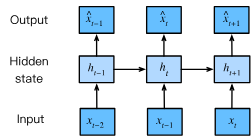

(Source: "Dive into Deep Learning" by Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola)

We can view this, from two perspectives, as a model that is recursively looping onto itself or as the unrolled variant, which generates a giant long feedforward graph with an identical weight matrix at every step.

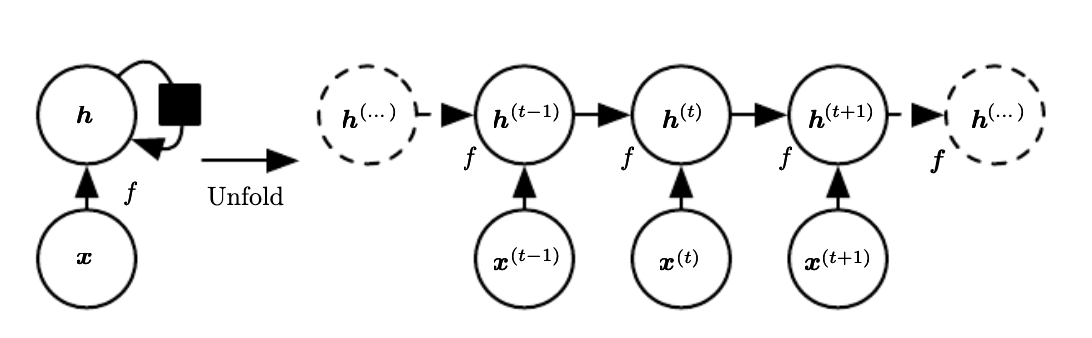

(Source: "Deep Learning Book" by Goodfellow, Bengio, and Courville)

But of course, what we care about is prediction, so we can use the hidden state to predict the next token $$P(x_{t+1}|h_t, x_t) = g(h_t, x_t)$$. This graph subsequently looks like this

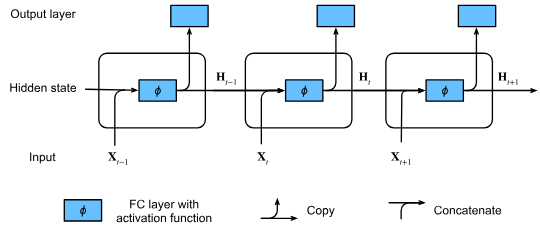

(Source: "Dive into Deep Learning" by Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola)

So what does this look like for an actual task we might care about? For example, for predicting the next character in a sentence it might look like
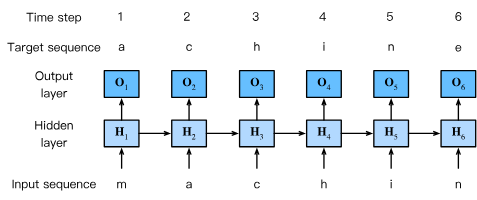

(Source: "Dive into Deep Learning" by Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola)
Here we started with the character "m" and asked the network to predict the next character. It predicted "a". Then given "a" as an input and the hidden state, it predicted "c". And so on. This output is often denoted as $$o_t$$. 

For each time-step, we can compare the prediction we did make with the actual value and use that to form a loss. This loss can be used to update the weights of the model. From this perspective, the whole graph looks like this

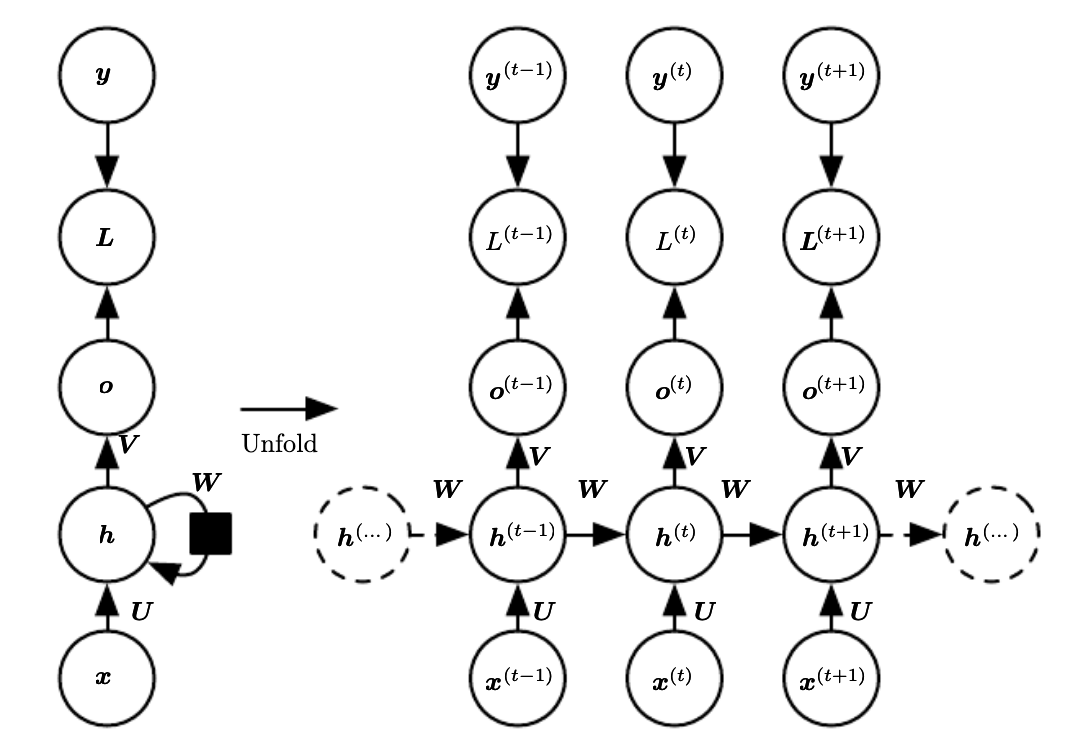

(Source: "Deep Learning Book" by Goodfellow, Bengio, and Courville)

where here the function $f$ used to update the hidden state is just a multiplication by a weight matrix.

Now, as something that's entirely abstract it's a little unclear, so lets actually build a network to do this type of prediction. 

## Starting with a simple example, redoing the sine wave

Epoch 1/5000, Loss: 6.715891
Epoch 2/5000, Loss: 6.713639
Epoch 3/5000, Loss: 6.169442
Epoch 4/5000, Loss: 6.026625
Epoch 5/5000, Loss: 6.243283
Epoch 6/5000, Loss: 5.802355
Epoch 7/5000, Loss: 5.994904
Epoch 8/5000, Loss: 6.353062
Epoch 9/5000, Loss: 6.589833
Epoch 10/5000, Loss: 6.940967
Epoch 11/5000, Loss: 5.951708
Epoch 12/5000, Loss: 6.070892
Epoch 13/5000, Loss: 6.116691
Epoch 14/5000, Loss: 6.367277
Epoch 15/5000, Loss: 5.901452
Epoch 16/5000, Loss: 6.123010
Epoch 17/5000, Loss: 6.131787
Epoch 18/5000, Loss: 5.728234
Epoch 19/5000, Loss: 6.152798
Epoch 20/5000, Loss: 6.084270
Epoch 21/5000, Loss: 6.383650
Epoch 22/5000, Loss: 6.552040
Epoch 23/5000, Loss: 6.057553
Epoch 24/5000, Loss: 5.975962
Epoch 25/5000, Loss: 6.322638
Epoch 26/5000, Loss: 5.599199
Epoch 27/5000, Loss: 5.913336
Epoch 28/5000, Loss: 5.941829
Epoch 29/5000, Loss: 6.050348
Epoch 30/5000, Loss: 5.928853
Epoch 31/5000, Loss: 6.017691
Epoch 32/5000, Loss: 5.979672
Epoch 33/5000, Loss: 5.735646
Epoch 34/5000, Loss

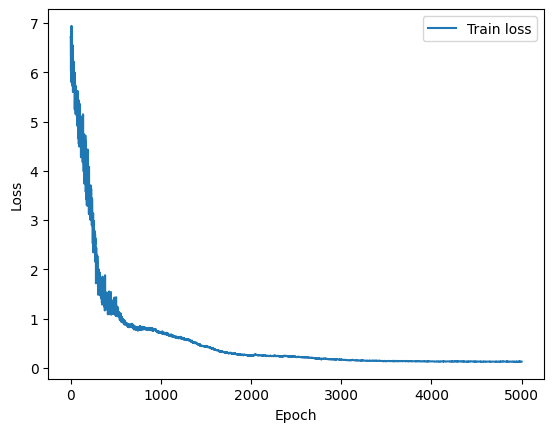

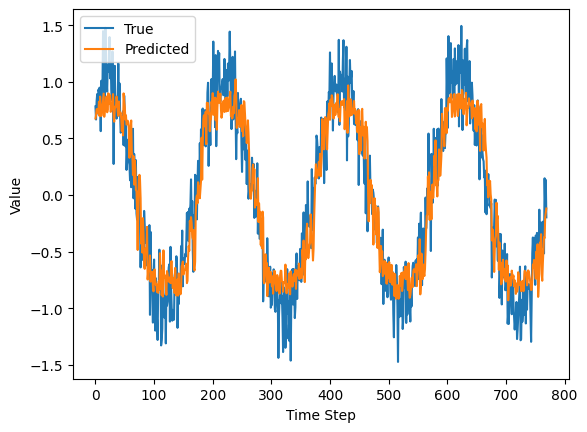

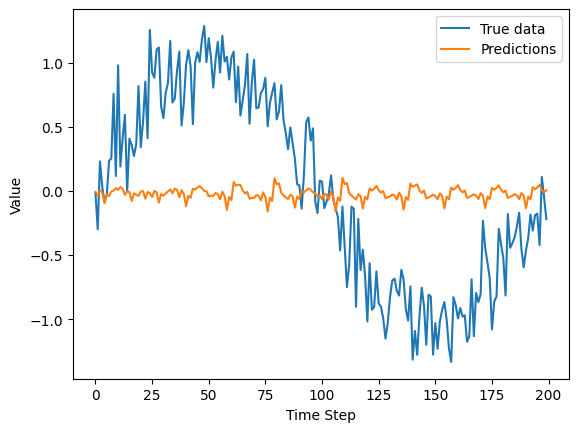

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Device configuration. For this class I'll use the GPU on my machine
# to make things faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size=10):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.W_xh = nn.Parameter(torch.randn(1, hidden_size))
        self.W_hy = nn.Parameter(torch.randn(hidden_size, 1))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        self.b_y = nn.Parameter(torch.zeros(1))
        
    def forward(self, xi, h=None):
        batch_size = xi.size(0)
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size).to(device)
        h = torch.tanh(torch.matmul(h, self.W_hh) + torch.matmul(xi, self.W_xh) + self.b_h)
        y_pred = torch.matmul(h, self.W_hy) + self.b_y
        return y_pred, h

# Multi-step prediction dataset
class MultiStepPredictionDataset(Dataset):
    def __init__(self, data, total_history, prediction_horizon=1):
        self.data = data
        self.total_history = total_history
        self.prediction_horizon = prediction_horizon
                
    def __len__(self):
        return len(self.data) - self.total_history - self.prediction_horizon + 1
            
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.total_history]
        y = self.data[idx+self.total_history:idx+self.total_history + self.prediction_horizon]
        return x, y

# Parameters
history_len = 30
prediction_horizon = 10
train_split = 0.8
max_grad_norm = 1
num_train = int(num_timepoints * train_split)
train_data = data[0, :num_train]
val_data = data[0, num_train:]

# Datasets and DataLoaders
train_dataset = MultiStepPredictionDataset(train_data, history_len, prediction_horizon=prediction_horizon)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

# Model, loss, optimizer
model = SimpleRNN(hidden_size=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 5000
train_losses = []

import random

teacher_forcing_ratio = 0.5  # You can adjust this value

for epoch in range(num_epochs):
    model.train()
    avg_train_loss = 0
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        h = None

        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Process the history to update h
        for t in range(history_len):
            xi = x_batch[:, t].unsqueeze(1)  # Shape: [batch_size, 1]
            _, h = model(xi, h)

        curr_loss = 0
        xi = x_batch[:, -1].unsqueeze(1)
        for t in range(prediction_horizon):
            y_pred, h = model(xi, h)
            y_true = y_batch[:, t]
            curr_loss += criterion(y_pred.squeeze(), y_true)

            # Decide whether to use teacher forcing
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

            if use_teacher_forcing:
                # Use ground truth as the next input
                xi = y_true.unsqueeze(1)
            else:
                # Use model's own prediction as the next input
                xi = y_pred.detach()  # Detach to prevent backpropagation through predictions

        # Average the loss over the prediction horizon
        curr_loss /= prediction_horizon
        curr_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        avg_train_loss += curr_loss.item()
        
        # Now gradually decrease the teacher forcing ratio
        teacher_forcing_ratio *= 0.999
    avg_train_loss /= len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')

# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate the training predictions
with torch.no_grad():
    predictions = []
    h = None
    x_seq = train_data[:history_len].to(device)
    # Process the history to update h
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h = model(xi, h)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(history_len, len(train_data)):
        y_pred, h = model(xi, h)
        predictions.append(y_pred.item())
        xi = train_data[i].unsqueeze(0).unsqueeze(1).to(device)  # Use true data for next input


# Plotting the training predictions
plt.figure()
plt.plot(train_data[history_len:].cpu().numpy(), label='True')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Autoregressive prediction on validation data
with torch.no_grad():
    predictions = []
    h = None
    # Use last history_len points from train_data to initialize h
    x_seq = train_data[-history_len:].to(device)
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h = model(xi, h)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(len(val_data)):
        y_pred, h = model(xi, h)
        predictions.append(y_pred.item())
        xi = y_pred  # Use model prediction as next input

# Plotting the validation predictions
plt.figure()
plt.plot(val_data.cpu().numpy(), label='True data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


## Lets try fancier architectures
The Vanilla RNN was up to snuff for prediction, but not autoregressive prediction! Lets try the LSTM that we discussed previously. I'll show you a from scratch implementation and then I'll also show you how to just use the default Torch version.

Epoch 1/2000, Loss: 11.636637
Epoch 2/2000, Loss: 11.755893
Epoch 3/2000, Loss: 12.683388
Epoch 4/2000, Loss: 11.783627
Epoch 5/2000, Loss: 12.154394
Epoch 6/2000, Loss: 12.120804
Epoch 7/2000, Loss: 11.524181
Epoch 8/2000, Loss: 11.947383
Epoch 9/2000, Loss: 11.785277
Epoch 10/2000, Loss: 12.452340
Epoch 11/2000, Loss: 12.144218
Epoch 12/2000, Loss: 11.458070
Epoch 13/2000, Loss: 11.789810
Epoch 14/2000, Loss: 11.258890
Epoch 15/2000, Loss: 11.513528
Epoch 16/2000, Loss: 11.703272
Epoch 17/2000, Loss: 12.681453
Epoch 18/2000, Loss: 11.522517
Epoch 19/2000, Loss: 10.885380
Epoch 20/2000, Loss: 11.341972
Epoch 21/2000, Loss: 11.541700
Epoch 22/2000, Loss: 11.391887
Epoch 23/2000, Loss: 10.884131
Epoch 24/2000, Loss: 11.236589
Epoch 25/2000, Loss: 10.947314
Epoch 26/2000, Loss: 10.873133
Epoch 27/2000, Loss: 11.218676
Epoch 28/2000, Loss: 11.187904
Epoch 29/2000, Loss: 11.312245
Epoch 30/2000, Loss: 11.433264
Epoch 31/2000, Loss: 11.473955
Epoch 32/2000, Loss: 11.973126
Epoch 33/2000, Lo

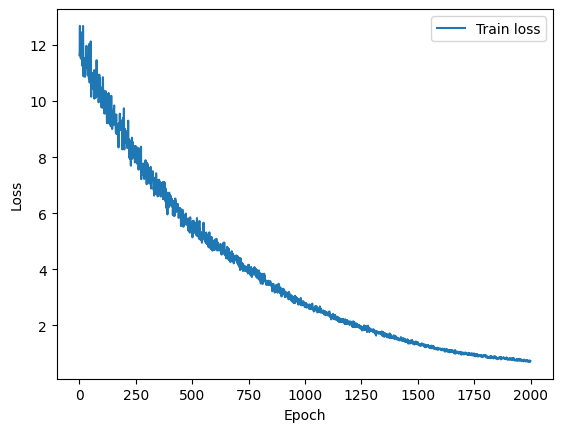

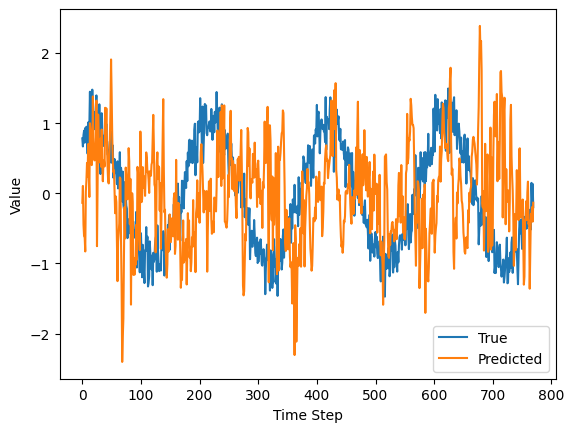

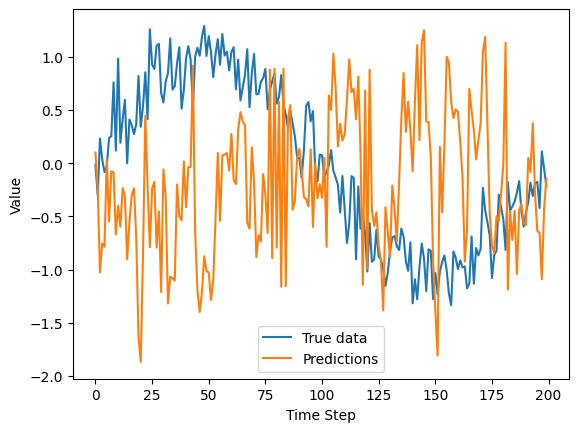

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Device configuration. For this class I'll use the GPU on my machine
# to make things faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LSTM model from scratch, not using Torch layer
class ScratchLSTM(nn.Module):
    def __init__(self, hidden_size=10):
        super(ScratchLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.W_f = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.W_i = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.W_o = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.W_c = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))
        self.W_hy = nn.Parameter(torch.randn(hidden_size, 1))
        self.b_y = nn.Parameter(torch.zeros(1))
    
    def forward(self, xi, h=None, c=None):
        batch_size = xi.size(0)
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size).to(device)
        if c is None:
            c = torch.zeros(batch_size, self.hidden_size).to(device)
        combined = torch.cat((xi, h), dim=1)
        f = torch.sigmoid(torch.matmul(combined, self.W_f.squeeze()) + self.b_f)
        i = torch.sigmoid(torch.matmul(combined, self.W_i.squeeze()) + self.b_i)
        o = torch.sigmoid(torch.matmul(combined, self.W_o.squeeze()) + self.b_o)
        c_hat = torch.tanh(torch.matmul(combined, self.W_c.squeeze()) + self.b_c)
        c = f * c + i * c_hat
        h = o * torch.tanh(c)
        y_pred = torch.matmul(h, self.W_hy) + self.b_y
        return y_pred, h, c
    
# This is the simplified torch module and what you'd probably actually use
class TorchLSTM(nn.Module):
    def __init__(self, hidden_size=10):
        super(TorchLSTM, self).__init__()
        # This lets us use the LSTM layer in PyTorch
        # batch_first means that the input and output tensors are provided as (batch, seq, feature)
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x, h=None, c=None):
        out, (h, c) = self.lstm(x.unsqueeze(-1), (h.unsqueeze(0), c.unsqueeze(0)))
        y_pred = self.linear(out.squeeze())
        return y_pred, h.squeeze(0), c.squeeze(0)

# Parameters
history_len = 30
prediction_horizon = 10
train_split = 0.8
max_grad_norm = 1
num_train = int(num_timepoints * train_split)
train_data = data[0, :num_train]
val_data = data[0, num_train:]

# Datasets and DataLoaders
train_dataset = MultiStepPredictionDataset(train_data, history_len, prediction_horizon=prediction_horizon)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

# Model, loss, optimizer
model = ScratchLSTM(hidden_size=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 5000
train_losses = []

import random

teacher_forcing_ratio = 0.5  # You can adjust this value

for epoch in range(num_epochs):
    model.train()
    avg_train_loss = 0
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        h = None
        c = None

        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Process the history to update h
        for t in range(history_len):
            xi = x_batch[:, t].unsqueeze(1)  # Shape: [batch_size, 1]
            _, h, c = model(xi, h, c)

        curr_loss = 0
        xi = x_batch[:, -1].unsqueeze(1)
        for t in range(prediction_horizon):
            y_pred, h, c = model(xi, h, c)
            y_true = y_batch[:, t]
            curr_loss += criterion(y_pred.squeeze(), y_true)

            # Decide whether to use teacher forcing
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

            if use_teacher_forcing:
                # Use ground truth as the next input
                xi = y_true.unsqueeze(1)
            else:
                # Use model's own prediction as the next input
                xi = y_pred.detach()  # Detach to prevent backpropagation through predictions

        # Average the loss over the prediction horizon
        curr_loss /= prediction_horizon
        curr_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        avg_train_loss += curr_loss.item()
        
        # Now gradually decrease the teacher forcing ratio
        teacher_forcing_ratio *= 0.999
    avg_train_loss /= len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')

# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate the training predictions
with torch.no_grad():
    predictions = []
    h = None
    c = None
    x_seq = train_data[:history_len].to(device)
    # Process the history to update h
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h, c = model(xi, h, c)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(history_len, len(train_data)):
        y_pred, h, c = model(xi, h, c)
        predictions.append(y_pred.item())
        xi = train_data[i].unsqueeze(0).unsqueeze(1).to(device)  # Use true data for next input


# Plotting the training predictions
plt.figure()
plt.plot(train_data[history_len:].cpu().numpy(), label='True')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Autoregressive prediction on validation data
with torch.no_grad():
    predictions = []
    h = None
    c = None
    # Use last history_len points from train_data to initialize h
    x_seq = train_data[-history_len:].to(device)
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h, c = model(xi, h, c)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(len(val_data)):
        y_pred, h, c = model(xi, h, c)
        predictions.append(y_pred.item())
        xi = y_pred  # Use model prediction as next input

# Plotting the validation predictions
plt.figure()
plt.plot(val_data.cpu().numpy(), label='True data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


It's not great, but it's our first partial success!! Autoregressive prediction is hard ya'll.

## Now lets do some character prediction because it's fun!

In [70]:
# We need to load up some character data. A common one is the text of Shakespeare's plays
import urllib.request
url = 'https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt'
response = urllib.request.urlopen(url)
data = response.read()
text = data.decode('utf-8')
print(text[:1000])

# we don't want to work with too much text so lets do
text = text[:100000]


This is the 100th Etext file presented by Project Gutenberg, and
is presented in cooperation with World Library, Inc., from their
Library of the Future and Shakespeare CDROMS.  Project Gutenberg
often releases Etexts that are NOT placed in the Public Domain!!

Shakespeare

*This Etext has certain copyright implications you should read!*

<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM
SHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS
PROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE
WITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE
DISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS
PERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED
COMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY
SERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>

*Project Gutenberg is proud to cooperate with The World Library*
in the presentation of The Complete Works of William Shakespeare
for your reading for educatio

Epoch 1/10, Loss: 3.092340
Epoch 2/10, Loss: 2.666923
Epoch 3/10, Loss: 2.426895
Epoch 4/10, Loss: 2.289866
Epoch 5/10, Loss: 2.201510
Epoch 6/10, Loss: 2.122288
Epoch 7/10, Loss: 2.055447
Epoch 8/10, Loss: 1.980834
Epoch 9/10, Loss: 1.916000
Epoch 10/10, Loss: 1.858516


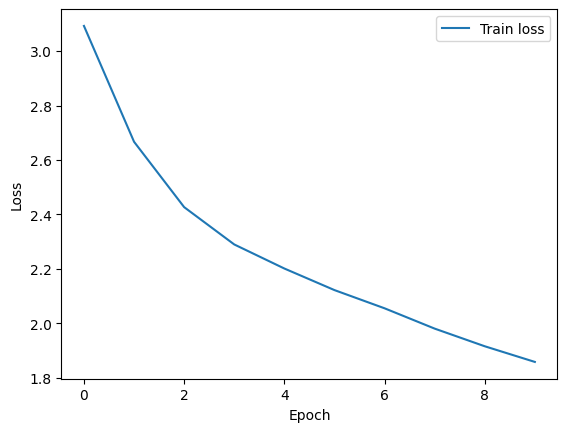

In [72]:
# Okay! Lets turn this into a dataset that we can use for training
# We will use a sequence length of 100 characters

class ShakespeareDataset(Dataset):
    def __init__(self, text, seq_len=100):
        self.text = text
        self.seq_len = seq_len
        # we need to convert the text into a set of unique characters
        # we also need to create a mapping from characters to indices
        # that we will eventually convert into one-hot vectors
        self.chars = sorted(list(set(text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        
    def __len__(self):
        return len(self.text) - self.seq_len
    
    def __getitem__(self, idx):
        x_str = self.text[idx:idx+self.seq_len]
        y_str = self.text[idx+1:idx+self.seq_len+1]
        x = torch.tensor([self.char_to_idx[ch] for ch in x_str])
        y = torch.tensor([self.char_to_idx[ch] for ch in y_str])
        # One-hot encode x only
        x = torch.nn.functional.one_hot(x, num_classes=len(self.chars)).float()
        # Do not one-hot encode y
        return x, y

# Lets create a dataset and dataloader
dataset = ShakespeareDataset(text)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)

# We also need a model that actually outputs predictions of the correct shape
# and has a softmax to convert the output into probabilities
# Note that the inputs are one-hot so they're the length of the number of characters
class TorchLSTM(nn.Module):
    def __init__(self, hidden_size=512):
        super(TorchLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=len(dataset.chars), hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, len(dataset.chars))
        
    def forward(self, x, h=None, c=None):
        if h is None or c is None:
            # Initialize h and c with the correct shape: (num_layers, batch_size, hidden_size)
            h = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
            c = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, (h, c) = self.lstm(x, (h, c))
        y_pred = self.linear(out)
        return y_pred

# create our model
model = TorchLSTM(hidden_size=512).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
train_losses = []

for i in range(num_epochs):
    model.train()
    avg_train_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        # y_pred shape: (batch_size, seq_len, num_classes)
        # y shape: (batch_size, seq_len)
        loss = criterion(y_pred.permute(0, 2, 1), y)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    avg_train_loss /= len(dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {i+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')

# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # Now lets generate some text!
# def generate_text(model, dataset, seed_text, length=1000, temperature=0.1):
    
                  

In [73]:
# Now let's generate some text!
def generate_text(model, dataset, seed_text, length=1000, temperature=0.1):
    model.eval()  # Set the model to evaluation mode
    generated_text = seed_text
    h = torch.zeros(1, 1, model.lstm.hidden_size).to(device)
    c = torch.zeros(1, 1, model.lstm.hidden_size).to(device)
    
    # Process the seed_text to initialize hidden and cell states
    with torch.no_grad():
        for char in seed_text[:-1]:
            if char in dataset.char_to_idx:
                idx = dataset.char_to_idx[char]
                input_tensor = torch.nn.functional.one_hot(
                    torch.tensor([idx]), num_classes=len(dataset.chars)
                ).float().unsqueeze(0).to(device)  # Shape: (1, 1, num_classes)
                _, (h, c) = model.lstm(input_tensor, (h, c))
            else:
                continue  # Skip characters not in the dataset

        last_char = seed_text[-1]
        for _ in range(length):
            if last_char in dataset.char_to_idx:
                idx = dataset.char_to_idx[last_char]
            else:
                idx = torch.randint(0, len(dataset.chars), (1,)).item()  # Random character
            input_tensor = torch.nn.functional.one_hot(
                torch.tensor([idx]), num_classes=len(dataset.chars)
            ).float().unsqueeze(0).to(device)  # Shape: (1, 1, num_classes)
            output, (h, c) = model.lstm(input_tensor, (h, c))
            logits = model.linear(output.squeeze(1))  # Shape: (1, num_classes)
            logits = logits / temperature  # Apply temperature
            probabilities = torch.softmax(logits, dim=-1)
            idx = torch.multinomial(probabilities, 1).item()
            next_char = dataset.idx_to_char[idx]
            generated_text += next_char
            last_char = next_char  # Update last_char for next iteration

    return generated_text

seed_text = "To be, or not to be, that is the question:\n"
generated = generate_text(model, dataset, seed_text, length=1000, temperature=0.5)
print(generated)

To be, or not to be, that is the question:
  Not leak of the what in the ered and hed thy sweet,
  So gomes on thet in thou deer that seren,
    The eants and that with is hame on the dore thet sell,
    But the sull asound then me practers mo hen thine still the eres of and me,
  Thy promed to the for the reast that whece beausure,
    The beauty of the wertored and the pear shee shan the stees do hald,
  When me sull this be of the srey berus lead,
  And love shall that is sand, not self the songed,
  When thy their and be ald me I sond that heart reod,
    I since still the waines that when beling be shink his the sand,
  Re the eres that seast me trous fare the fullos not seren of thee,
  Ot no the will of the eremy wort the beauty the prees.
    For whet bets in the parts conkends all thee my ele,
  And not sheal not in the of the repers of thou me lease,
  And werter and the it the haids and thee,
  Whe have with the rest fore my has my near is the werte thy seave,
  That do dour